# Loading of packages 

In [1]:
import tensorflow as tf
from tensorflow import keras
import openpyxl
from keras import layers
import pyarrow as pa
import pyarrow.parquet as pq
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers,models,callbacks
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
import numpy as np
import shutil
import glob
import pandas as pd
import dask
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from umap import UMAP
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import os
import time
from io import StringIO
from joblib import Parallel, delayed




print(os.getcwd())
print(keras.__version__)
print(pd.__version__)
print(dask.__version__)

#Ensure reproductibility
seed=42

/Users/safaakassioui/Documents/IA_DL/projet
3.11.3
2.3.2
2024.8.2


# Load the dataset and metadata

In [2]:
expr = pd.read_csv('/Users/safaakassioui/Documents/IA_DL/projet/dataset /tcga_expression_matrix_allcopie.tsv', sep="\t", index_col=0)

print("Patients dans le fichier :", expr.shape[0])

Patients dans le fichier : 755


In [3]:
print("Patients :", expr.shape[0])
print("Gènes :", expr.shape[1])

Patients : 755
Gènes : 60664


In [4]:
clinical = pd.read_csv("clinical_metadata.csv", index_col="Case_ID")
clinical.head()

,Final Pathology,PAM50,TumorPurity,ProliferationScore,mRNA,miRNA,SNP,Exome,Methylation,RPPA,...,Hormone_a score,Hormone_b score,PI3K/Akt score,Ras/MAPK score,RTK score,TSC/mTOR score,ISOpure,OncoSign,ElasticNet,Unnamed: 27
Case_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-BH-A18G,IDC,Basal,0.79,0.423067,TCGA-BH-A18G-01A-11R-A12D-07,TCGA-BH-A18G-01A-11R-A12C-13,TCGA-BH-A18G-01A-11D-A12A-01,TCGA-BH-A18G-01A-11D-A12B-09,TCGA-BH-A18G-01A-11D-A12E-05,TCGA-BH-A18G,...,-1.873243,-0.120416,-3.469006,0.943580,-1.421711,1.376493,NaN,NaN,NaN,IDC-like
TCGA-A1-A0SP,IDC,Basal,0.46,0.262933,TCGA-A1-A0SP-01A-11R-A084-07,TCGA-A1-A0SP-01A-11R-A085-13,TCGA-A1-A0SP-01A-11D-A087-01,TCGA-A1-A0SP-01A-11D-A099-09,TCGA-A1-A0SP-01A-11D-A10P-05,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ILC-like
TCGA-A2-A04P,IDC,Basal,0.60,0.445335,TCGA-A2-A04P-01A-31R-A034-07,TCGA-A2-A04P-01A-31R-A035-13,TCGA-A2-A04P-01A-31D-A036-01,TCGA-A2-A04P-01A-31D-A128-09,TCGA-A2-A04P-01A-31D-A032-05,TCGA-A2-A04P,...,-0.032671,-0.725427,0.990956,-0.389598,0.047441,1.079578,NaN,NaN,NaN,NaN
TCGA-A2-A04Q,IDC,Basal,0.17,0.189018,TCGA-A2-A04Q-01A-21R-A034-07,TCGA-A2-A04Q-01A-21R-A035-13,TCGA-A2-A04Q-01A-21D-A036-01,TCGA-A2-A04Q-01A-21W-A050-09,TCGA-A2-A04Q-01A-21D-A032-05,TCGA-A2-A04Q,...,-0.114763,1.403402,-1.737561,2.117965,2.489667,-1.303777,NaN,NaN,NaN,NaN
TCGA-A2-A04T,IDC,Basal,0.61,0.376498,TCGA-A2-A04T-01A-21R-A034-07,TCGA-A2-A04T-01A-21R-A035-13,TCGA-A2-A04T-01A-21D-A036-01,TCGA-A2-A04T-01A-21W-A050-09,TCGA-A2-A04T-01A-21D-A032-05,TCGA-A2-A04T,...,-1.576243,-1.533891,0.750345,1.040222,0.608384,-1.294638,NaN,NaN,NaN,NaN


# Create main Dataset : IDC, ILC, Mixed

In [5]:
clinical["Final Pathology"].value_counts(dropna=False)

Final Pathology
IDC              490
ILC              127
Other            112
Mixed.IDC.ILC     88
Name: count, dtype: int64

In [ ]:
# We keep only tha patient with IDC or ILC or mixed 
clinical_main = clinical[clinical["Final Pathology"].isin(["IDC", "ILC", "Mixed.IDC.ILC"])]
expr_main = expr.loc[expr.index.intersection(clinical_main.index)]

expr_main.shape
clinical_main.loc[expr_main.index, "Final Pathology"].value_counts()

Final Pathology
IDC              431
ILC              127
Mixed.IDC.ILC     88
Name: count, dtype: int64

In [7]:
expr_main.columns[:10]

Index(['Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'TSPAN6',
       'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR'],
      dtype='object')

In [8]:
expr_main = expr_main.loc[:, ~expr_main.columns.str.startswith("Unnamed")] # [lignes,colonnes], loc -> acceder aux labels donc nom de genes

In [9]:
expr_main.columns[:10]

Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA'],
      dtype='object')

In [10]:
expr_main.isna().sum().sum()

0

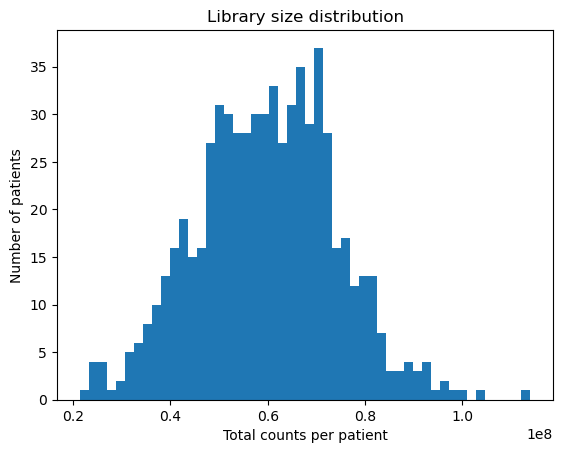

In [11]:
library_size = expr_main.sum(axis=1)

plt.hist(library_size, bins=50)
plt.xlabel("Total counts per patient")
plt.ylabel("Number of patients")
plt.title("Library size distribution")
plt.show()

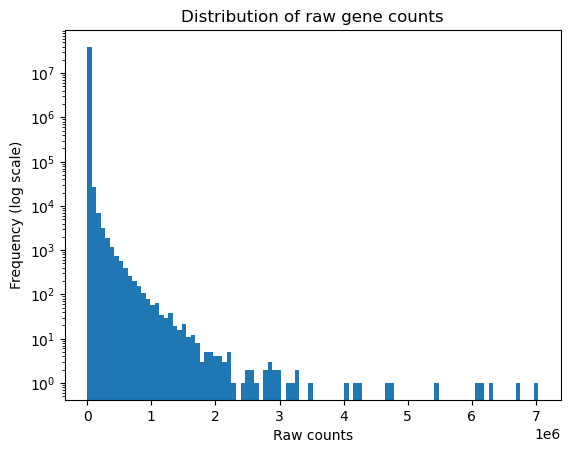

In [12]:
plt.hist(expr_main.values.flatten(), bins=100, log=True)
plt.xlabel("Raw counts")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of raw gene counts")
plt.show()

# Gene filtering 

In [13]:
min_count = 10
min_frac = 0.20

keep_genes = (expr_main >= min_count).mean(axis=0) >= min_frac
expr_filt = expr_main.loc[:, keep_genes]

expr_main.shape, expr_filt.shape

((646, 60660), (646, 23799))

# Normalization

In [14]:
X = expr_filt.copy()
uq = X.where(X > 0).quantile(0.75, axis=1)
X_uq = X.div(uq, axis=0)
X_uq = X_uq * np.nanmedian(uq)
X_uq_log = np.log2(X_uq + 1)

In [15]:
library_size = expr_filt.sum(axis=1)
X_cpm = expr_filt.div(library_size, axis=0) * 1e6
X_cpm_log = np.log2(X_cpm + 1)

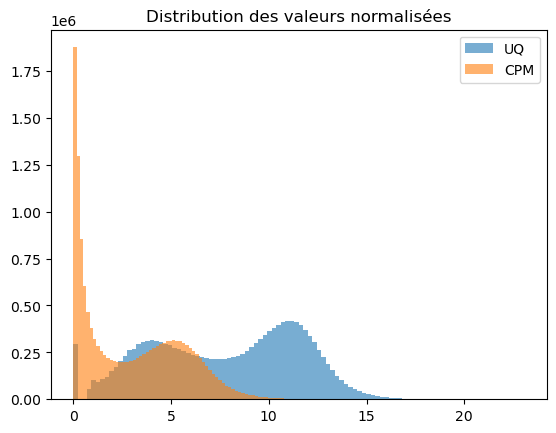

In [16]:
plt.hist(X_uq_log.values.flatten(), bins=100, alpha=0.6, label="UQ")
plt.hist(X_cpm_log.values.flatten(), bins=100, alpha=0.6, label="CPM")
plt.legend()
plt.title("Distribution des valeurs normalisées")
plt.show()

# HVG 

In [17]:
# calcul la variance de chaque gene entre les patients 
gene_var = X_uq.var(axis=0)

# selection des n genes les plus variables 
n = 2000
hvg = gene_var.sort_values(ascending=False).head(n).index

expr_hvg = X_uq[hvg]

# Scaling 

In [18]:
scaler = StandardScaler()
expr_hvg_scaled = pd.DataFrame(
    scaler.fit_transform(expr_hvg),
    index=expr_hvg.index,
    columns=expr_hvg.columns
)

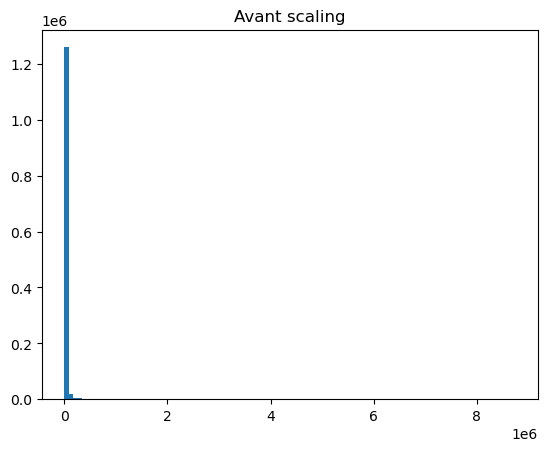

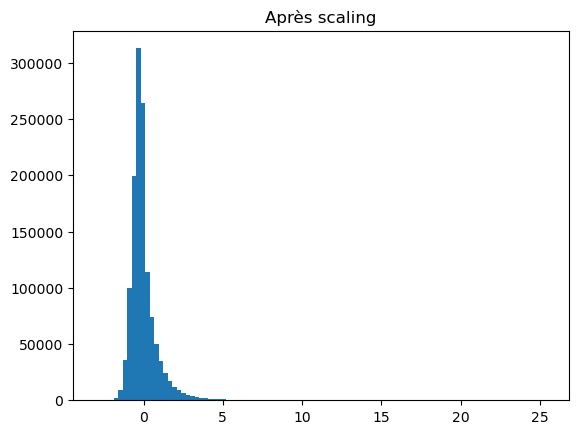

In [19]:
plt.hist(expr_hvg.values.flatten(), bins=100)
plt.title("Avant scaling")
plt.show()

plt.hist(expr_hvg_scaled.values.flatten(), bins=100)
plt.title("Après scaling")
plt.show()

In [20]:
expr_hvg_scaled.to_csv("TCGA_IDC_ILC_Mixed.tsv", sep="\t")

In [21]:
# masque IDC + ILC
mask_idc_ilc = clinical["Final Pathology"].isin(["IDC", "ILC"])

# sous-dataset HVG scalé (IDC + ILC uniquement)
expr_hvg_scaled_idc_ilc = expr_hvg_scaled.loc[mask_idc_ilc]

In [23]:
expr_hvg_scaled_idc_ilc.shape

(558, 2000)

In [22]:
expr_hvg_scaled_idc_ilc.to_csv("TCGA_IDC_ILC.tsv", sep="\t")